In [305]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets

In [306]:
parasitized_path='C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory/cell-images-for-detecting-malaria/cell_images/Parasitized/'
uninfected_path='C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory/cell-images-for-detecting-malaria/cell_images/Uninfected/'
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [307]:
parasitized_labels=os.listdir('C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory/cell-images-for-detecting-malaria/cell_images/Parasitized')
uninfected_labels=os.listdir('C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory/cell-images-for-detecting-malaria/cell_images/Uninfected')

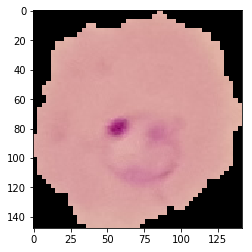

In [308]:
plt.imshow(io.imread(parasitized_path+parasitized_labels[0]))

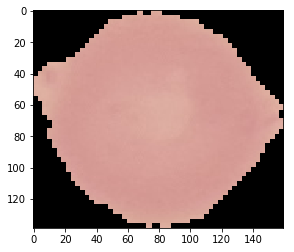

In [309]:
plt.imshow(io.imread(uninfected_path+uninfected_labels[0]))

In [310]:
io.imread(uninfected_path+uninfected_labels[0]).shape

(139, 160, 3)

In [311]:
transform=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize([0.13,0.251,0.339],[1,1,1])])

In [312]:
data = datasets.ImageFolder(root='C:/Users/DHRUVIL/OneDrive/Stratsntools/Python Directory/cell-images-for-detecting-malaria/cell_images/',
                                      transform=transform)

In [314]:
df_size=len(data)
print('Size = {}'.format(df_size))

Size = 27558


In [315]:
VALIDATION_SIZE=0.2
indices = list(range(df_size))
val_split = int(np.floor(VALIDATION_SIZE*df_size))
np.random.seed(123)
np.random.shuffle(indices)

In [316]:
train_indices,val_indices=indices[val_split:],indices[:val_split]

In [317]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler=SubsetRandomSampler(train_indices)
val_sampler=SubsetRandomSampler(val_indices)

In [318]:
train_loader=torch.utils.data.DataLoader(data,sampler=train_sampler,batch_size=10)
val_loader=torch.utils.data.DataLoader(data,sampler=val_sampler,batch_size=10)

In [319]:
len(val_sampler.indices)

5511

In [326]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)#Convolution layer for 3 channels, 9 filters, 3 by 3 size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(9, 16, 3)
        # an affine operation : y = Wx + b
        self.fc1 = nn.Linear(16*6*6, 288)
        self.fc2 = nn.Linear(288, 72)
        self.fc3 = nn.Linear(72, 2)
        
    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = x.view(-1, 16*6*6)#-1 means that we define one dimension. The other one is calculated automatically.
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)

        return x
    
net = ConvNet()
net=ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=2, bias=True)
)


In [327]:
params=list(net.parameters())
print(len(params))
print(params[0].size)

10
<built-in method size of Parameter object at 0x0000022ABC7696C0>


In [330]:
criteria=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.8)
NUM_EPOCHS=6
for epoch in range(NUM_EPOCHS):
    running_loss=0
    print("%{}".format(epoch*100/NUM_EPOCHS))
    for i, data in enumerate(train_loader):
        # get the input
#        print(i)
        inputs, labels = data

        # zero the parameters
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')


%0.0
%16.666666666666668
%33.333333333333336
%50.0
%66.66666666666667
%83.33333333333333
Finished Training


In [331]:
print("\nValidation:")

correct = 0
total = 0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for i,data in enumerate(val_loader):
        images, labels = data
        num_of_imgs = labels.shape[0]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        if labels.shape[0] == 1:  # Batch of size 1 causes problems
            c = [c]
        c_size = len(c)

        for i in range(c_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("Size of classes: ", class_total)

print('Accuracy of the network on %d validation images: %d %%' % (len(val_loader), 100 * correct / total))
classes = ('Parasitized', 'Uninfected')
for i in range(2):
    print('Accuracy of validation %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


Validation:
Size of classes:  [2767.0, 2744.0]
Accuracy of the network on 552 validation images: 93 %
Accuracy of validation Parasitized : 91 %
Accuracy of validation Uninfected : 96 %
